In [1]:
model_path="./experiments/celeba_5bit/models/most_recent.pth"
data_path="./celeba/img_align_celeba"

In [2]:
from PIL import Image
from torchvision import transforms
img_pil1 = Image.open("./experiments/celeba_5bit/imgs/e090_i000000.png")#.convert('RGB')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def show(img, fig_size=(12,8)):
    npimg = img.numpy()
    fig = plt.figure(figsize=fig_size, dpi=100) 
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')   

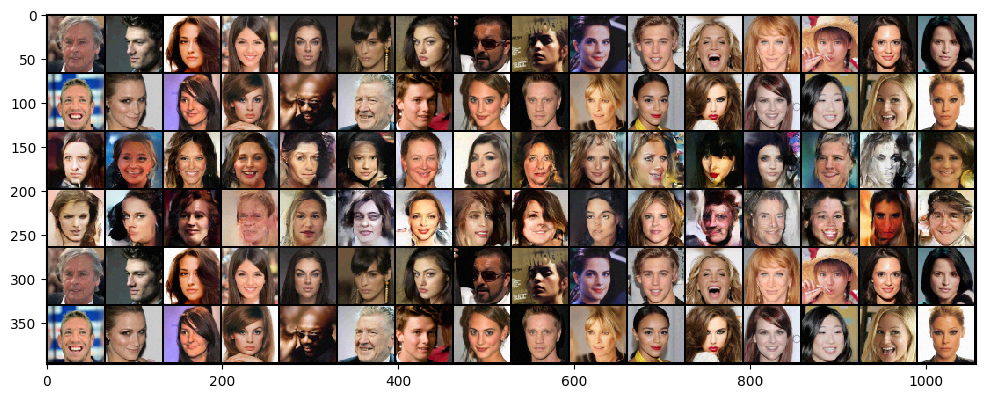

In [4]:
transform = transforms.ToTensor()
tensor_imgs = transform(img_pil1) 
show(reversed(tensor_imgs))

In [5]:
tensor_imgs.shape

torch.Size([3, 398, 1058])

In [6]:
import argparse
import time
import math
import os
import os.path
import numpy as np
from tqdm import tqdm
import gc

import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import torchvision.datasets as vdsets

from lib.resflow import ACT_FNS, ResidualFlow
import lib.datasets as datasets
import lib.optimizers as optim
import lib.utils as utils
import lib.layers as layers
import lib.layers.base as base_layers
from lib.lr_scheduler import CosineAnnealingWarmRestarts

import logging

In [7]:
checkpoint = torch.load(model_path)
args = checkpoint['args']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
args.resume = model_path
args.nworkers = 1

In [9]:
logger = utils.get_logger(logpath=os.path.join(args.save, 'logs'), filepath=os.path.abspath("./train_img.py"))
logger.info(args)

/home/george/Projects/cognitive/proj/residual-flows/train_img.py
import argparse
import time
import math
import os
import os.path
import numpy as np
from tqdm import tqdm
import gc

import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.datasets as vdsets

from lib.resflow import ACT_FNS, ResidualFlow
import lib.datasets as datasets
import lib.optimizers as optim
import lib.utils as utils
import lib.layers as layers
import lib.layers.base as base_layers
from lib.lr_scheduler import CosineAnnealingWarmRestarts

# Arguments
parser = argparse.ArgumentParser()
parser.add_argument(
    '--data', type=str, default='cifar10', choices=[
        'mnist',
        'cifar10',
        'svhn',
        'celebahq',
        'celeba_5bit',
        'imagenet32',
        'imagenet64',
    ]
)
parser.add_argument('--dataroot', type=str, default='data')
parser.add_argument('--imagesize', type=int, default=32)
parser.add_argument('--nbits', type=i

Namespace(act='elu', actnorm=True, add_noise=True, annealing_iters=0, batchnorm=False, batchsize=32, begin_epoch=0, block='resblock', cdim=256, coeff=0.98, data='celeba_5bit', dataroot='data', dropout=0.0, ema_val=True, factor_out=True, fc=False, fc_actnorm=False, fc_end=False, fc_idim=128, first_resblock=True, idim=512, imagesize=64, kernels='3-1-3', learn_p=False, lr=0.001, mem_eff=True, n_dist='poisson', n_exact_terms=2, n_lipschitz_iters=None, n_power_series=None, n_samples=1, nbits=5, nblocks='16-16-16-16', nepochs=1000, neumann_grad=True, nworkers=1, optimizer='adam', padding=0, padding_dist='uniform', preact=True, print_freq=20, quadratic=False, rcrop_pad_mode='reflect', resume='./experiments/celeba_5bit/models/most_recent.pth', save='experiments/celeba_5bit', scale_dim=False, scheduler=False, seed=43473, sn_tol=0.001, squeeze_first=True, task='density', update_freq=1, val_batchsize=200, var_reduc_lr=0, vis_freq=500, vnorms='2222', warmup_iters=1000, wd=0)


In [10]:
im_dim = 3
init_layer = layers.LogitTransform(0.05)
if args.imagesize != 64:
    logger.info('Changing image size to 64.')
    args.imagesize = 64
    
def add_noise(x, nvals=256):
    """
    [0, 1] -> [0, nvals] -> add noise -> [0, 1]
    """
    if args.add_noise:
        noise = x.new().resize_as_(x).uniform_()
        x = x * (nvals - 1) + noise
        x = x / nvals
    return x
    
train_loader = torch.utils.data.DataLoader(
    datasets.CelebA5bit(
        train=True, transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            lambda x: add_noise(x, nvals=32),
        ])
    ), batch_size=args.batchsize, shuffle=True, num_workers=args.nworkers
)
test_loader = torch.utils.data.DataLoader(
    datasets.CelebA5bit(train=False, transform=transforms.Compose([
        lambda x: add_noise(x, nvals=32),
    ])), batch_size=args.val_batchsize, shuffle=False, num_workers=args.nworkers
)

In [11]:
if args.task in ['classification', 'hybrid']:
    try:
        n_classes
    except NameError:
        raise ValueError('Cannot perform classification with {}'.format(args.data))
else:
    n_classes = 1

logger.info('Dataset loaded.')
logger.info('Creating model.')

input_size = (args.batchsize, im_dim + args.padding, args.imagesize, args.imagesize)
dataset_size = len(train_loader.dataset)

if args.squeeze_first:
    input_size = (input_size[0], input_size[1] * 4, input_size[2] // 2, input_size[3] // 2)
    squeeze_layer = layers.SqueezeLayer(2)

# Model
model = ResidualFlow(
    input_size,
    n_blocks=list(map(int, args.nblocks.split('-'))),
    intermediate_dim=args.idim,
    factor_out=args.factor_out,
    quadratic=args.quadratic,
    init_layer=init_layer,
    actnorm=args.actnorm,
    fc_actnorm=args.fc_actnorm,
    batchnorm=args.batchnorm,
    dropout=args.dropout,
    fc=args.fc,
    coeff=args.coeff,
    vnorms=args.vnorms,
    n_lipschitz_iters=args.n_lipschitz_iters,
    sn_atol=args.sn_tol,
    sn_rtol=args.sn_tol,
    n_power_series=args.n_power_series,
    n_dist=args.n_dist,
    n_samples=args.n_samples,
    kernels=args.kernels,
    activation_fn=args.act,
    fc_end=args.fc_end,
    fc_idim=args.fc_idim,
    n_exact_terms=args.n_exact_terms,
    preact=args.preact,
    neumann_grad=args.neumann_grad,
    grad_in_forward=args.mem_eff,
    first_resblock=args.first_resblock,
    learn_p=args.learn_p,
    classification=args.task in ['classification', 'hybrid'],
    classification_hdim=args.cdim,
    n_classes=n_classes,
    block_type=args.block,
)

model.to(device)
ema = utils.ExponentialMovingAverage(model)

Dataset loaded.
Creating model.


In [12]:
if (args.resume is not None):
    logger.info('Resuming model from {}'.format(args.resume))
    with torch.no_grad():
        x = torch.rand(1, *input_size[1:]).to(device)
        model(x)
    checkpt = torch.load(args.resume)
    sd = {k: v for k, v in checkpt['state_dict'].items() if 'last_n_samples' not in k}
    state = model.state_dict()
    state.update(sd)
    model.load_state_dict(state, strict=True)
    ema.set(checkpt['ema'])
#     if 'optimizer_state_dict' in checkpt:
#         optimizer.load_state_dict(checkpt['optimizer_state_dict'])
#         # Manually move optimizer state to GPU
#         for state in optimizer.state.values():
#             for k, v in state.items():
#                 if torch.is_tensor(v):
#                     state[k] = v.to(device)
    del checkpt
    del state

Resuming model from ./experiments/celeba_5bit/models/most_recent.pth


In [13]:
def normal_logprob(z, mean, log_std):
    mean = mean + torch.tensor(0.)
    log_std = log_std + torch.tensor(0.)
    c = torch.tensor([math.log(2 * math.pi)]).to(z)
    inv_sigma = torch.exp(-log_std)
    tmp = (z - mean) * inv_sigma
    return -0.5 * (tmp * tmp + 2 * log_std + c)

def add_padding(x, nvals=256):
    # Theoretically, padding should've been added before the add_noise preprocessing.
    # nvals takes into account the preprocessing before padding is added.
    if args.padding > 0:
        if args.padding_dist == 'uniform':
            u = x.new_empty(x.shape[0], args.padding, x.shape[2], x.shape[3]).uniform_()
            logpu = torch.zeros_like(u).sum([1, 2, 3]).view(-1, 1)
            return torch.cat([x, u / nvals], dim=1), logpu
        elif args.padding_dist == 'gaussian':
            u = x.new_empty(x.shape[0], args.padding, x.shape[2], x.shape[3]).normal_(nvals / 2, nvals / 8)
            logpu = normal_logprob(u, nvals / 2, math.log(nvals / 8)).sum([1, 2, 3]).view(-1, 1)
            return torch.cat([x, u / nvals], dim=1), logpu
        else:
            raise ValueError()
    else:
        return x, torch.zeros(x.shape[0], 1).to(x)


def remove_padding(x):
    if args.padding > 0:
        return x[:, :im_dim, :, :]
    else:
        return x

In [14]:
def visualize(model, real_imgs):
    model.eval()
    
    real_imgs = real_imgs[:32]
    _real_imgs = real_imgs

    if args.data == 'celeba_5bit':
        nvals = 32
    elif args.data == 'celebahq':
        nvals = 2**args.nbits
    else:
        nvals = 256

    with torch.no_grad():
        # reconstructed real images
        real_imgs, _ = add_padding(real_imgs, nvals)
        if args.squeeze_first: real_imgs = squeeze_layer(real_imgs)
        recon_imgs = model(model(real_imgs.view(-1, *input_size[1:])), inverse=True).view(-1, *input_size[1:])
        if args.squeeze_first: recon_imgs = squeeze_layer.inverse(recon_imgs)
        recon_imgs = remove_padding(recon_imgs)

        # random samples
        fake_imgs = model(fixed_z, inverse=True).view(-1, *input_size[1:])
        if args.squeeze_first: fake_imgs = squeeze_layer.inverse(fake_imgs)
        fake_imgs = remove_padding(fake_imgs)

        fake_imgs = fake_imgs.view(-1, im_dim, args.imagesize, args.imagesize)
        recon_imgs = recon_imgs.view(-1, im_dim, args.imagesize, args.imagesize)
        
    return _real_imgs, fake_imgs, recon_imgs

#         imgs = torch.cat([_real_imgs, fake_imgs, recon_imgs], 0).flip(dims=(1,))

#         filename = os.path.join(args.save, 'imgs', 'e{:03d}_i{:06d}.png'.format(epoch, itr))
#         save_image(imgs.cpu().float(), filename, nrow=16, padding=2)
#     model.train()

In [15]:
def standard_normal_sample(size):
    return torch.randn(size)

fixed_z = standard_normal_sample([min(32, args.batchsize),
                                  (im_dim + args.padding) * args.imagesize * args.imagesize]).to(device)

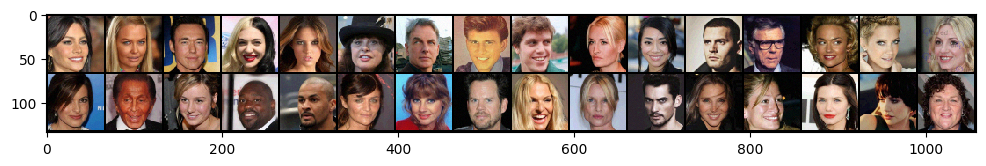

In [16]:
batch_input, _ = next(iter(test_loader))
show(make_grid(batch_input[:32].flip(dims=(1,)), normalize=True,
                        nrow=16,
                        range=(0, 1),))

In [17]:
id1, id2 = 1, 3 
x = torch.stack((batch_input[id1], batch_input[id2]), dim=0)

In [45]:
def load_external(path):
    from PIL import Image
    img_pil1 = Image.open(path).convert('RGB')
    # img_pil2 = Image.open("isabelle.png").convert('RGB')
    image_size = (64,64)
    transform=transforms.Compose([
                transforms.Resize(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                lambda x: add_noise(x, nvals=32),
            ])
    test1 = transform(img_pil1).flip(dims=(0,))
    return test1

x = torch.stack((
    load_external("../imgs/rachel.jpg"),
    load_external("../imgs/guy.jpg"),
), dim=0)

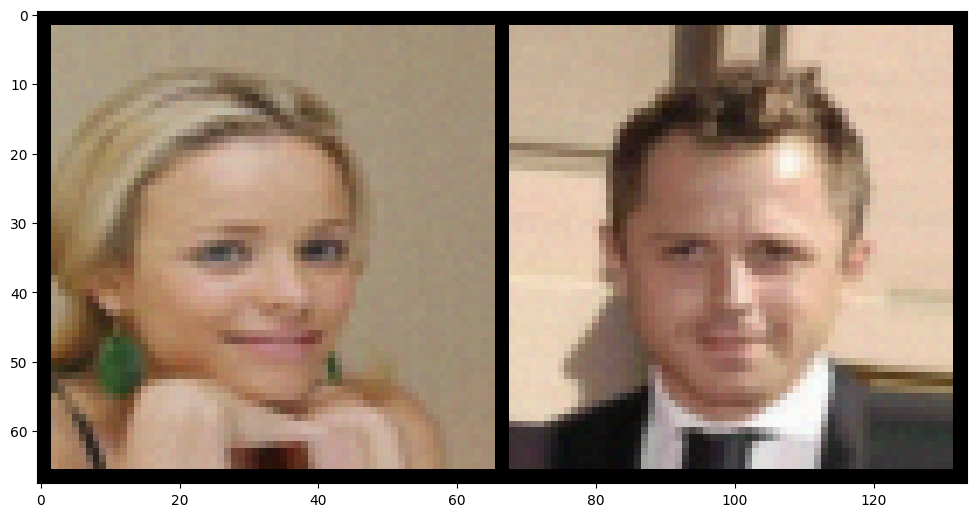

In [46]:
show(make_grid(x.flip(dims=(1,)), normalize=True,
                        nrow=2,
                        range=(0, 1),))

In [47]:
x = x.to(device)
if args.squeeze_first: x = squeeze_layer(x)
z = model(x.view(-1, *input_size[1:]))

In [48]:
z.shape

torch.Size([2, 12288])

In [51]:
# Linearly interpolate latent space
L = 5

space = torch.tensor(np.linspace(0,1,L)).type_as(z).view(-1, 1)
z_inters = (1-space)*z[0:1] + space*z[1:2]

torch.cuda.empty_cache()
with torch.no_grad():
    recon_imgs = model(z_inters, inverse=True).view(-1, *input_size[1:])
    if args.squeeze_first: recon_imgs = squeeze_layer.inverse(recon_imgs)
    recon_imgs = remove_padding(recon_imgs)
    recon_imgs = recon_imgs.view(-1, im_dim, args.imagesize, args.imagesize)

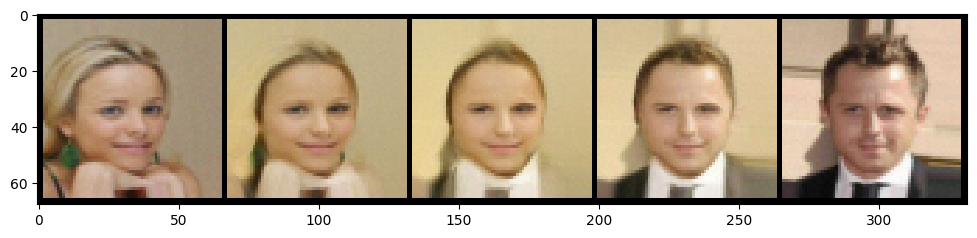

In [52]:
imgs = recon_imgs.flip(dims=(1,)).cpu().float()
show(make_grid(imgs, normalize=True,
                        nrow=L,
                        range=(0, 1),))

In [ ]:
test1.shape

In [ ]:
dist = torch.randn(100).abs() #test1.mean(0).view(-1)[15:50]
dist = dist / dist.sum() 
plt.bar(range(len(dist)), dist)